In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
import numpy as np

from pathlib import Path

# Surpress warnings related to NaNs
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
def get_range(coords, nvar, model_dir):
    """
    Get the maximal range of the predictions over all extraction points
    for one variable. This is used to align the histograms. 
    """
    # Convert nvar
    if nvar == 0:
        var = "Hs"
    elif nvar == 1:
        var = "Tm02"
    elif nvar == 2:
        var = "Dir"
    
    # Initiate min and max value
    min_val = np.inf
    max_val = -np.inf
    for coord in coords:
        # Load the prediction data
        x, y = coord[0], coord[1]
        path_dir = Path(f"./Data/Time_Series/{model_dir}")
        fpath = path_dir / f"Var_{var}_posxy_{x}_{y}.npy"
        prediction = np.load(fpath)[0, :]
        
        # Get lowest and highest values without counting nan
        min_pred, max_pred = np.nanmin(prediction), np.nanmax(prediction)
        if min_pred < min_val:
            min_val = min_pred
        if max_pred > max_val:
            max_val = max_pred
            
    return min_val, max_val


def get_plotting_data(nvar, xi, yi, model_dir, var, npts, nbox, min_max_range):
    """
    Compute the mean error and difference over nbox boxes and return 
    them, plus their standard deviation.
    """
    prediction = []
    HR = []
    LR = []
    HR_train = []

    for j, coords in enumerate(zip(xi, yi)):
        x, y = coords[0], coords[1]


        # Load time series of predictions and training data
        path_dir = Path(f"Data/Time_Series/{model_dir}")
        
        fpath = path_dir / f"Var_{var[nvar]}_posxy_{x}_{y}.npy"
        fpath_train = path_dir / f"Ref_Var_{var[nvar]}_posxy_{x}_{y}.npy"

        arr = np.load(fpath)
        arr_train = np.load(fpath_train)

        prediction.append(arr[0, :])
        HR.append(arr[1, :])
        LR.append(arr[2, :])
        HR_train.append(arr_train)
        
    # Compute Error and Difference for all extraction points
    diff = []

    # Loop over all points
    for i in range(npts):
        difference = np.abs(HR[i] - prediction[i])
        diff.append(difference)


    # Get the partition of the variable value with the help of a histogram
    _, edges = np.histogram(prediction[0], nbox, range=min_max_range)
    
    # From edges create an array with the middle position
    mid_pos = ((edges + np.roll(edges, 1))/2)[1:]

    # Create a list that will contain the data for all the boxes
    box_NRMSE = np.empty((npts, nbox))
    box_diff = np.empty((npts, nbox))
    box_diff_std = np.empty((npts, nbox))

    for i in range(npts):
        for j in range(nbox):
            # Extract all data points in one box and compute mean
            condition = ((edges[j] <= prediction[i]) &
                         (prediction[i] < edges[j+1]))
            
            data_diff = diff[i][condition]
            mean = np.nanmean(HR[i][condition])
            box_NRMSE[i, j] = np.sqrt(np.nanmean(data_diff**2))/mean*100
            box_diff[i, j] = np.mean(data_diff)
            box_diff_std[i, j] = np.std(data_diff)
            
            
    return box_NRMSE, box_diff, box_diff_std, mid_pos, HR_train

In [3]:
# Model directory
model_dir = "SuperResolution"

# Define the range of the time series
var = {0: "Hs", 1: "Tm02", 2: "Dir"}

sample_start = 8761
sample_end = 17496

sample_train_start = 24
sample_train_end = 8760


# Define the point where the time series is extracted (in pixel)
xi = [69, 86, 69]
yi = [94, 104, 77] 

# Define length of extraction points for easier acess
npts = len(xi)

# Number of boxes
nbox = 12

# Save the figure?
save = True

# Plot for all three variables

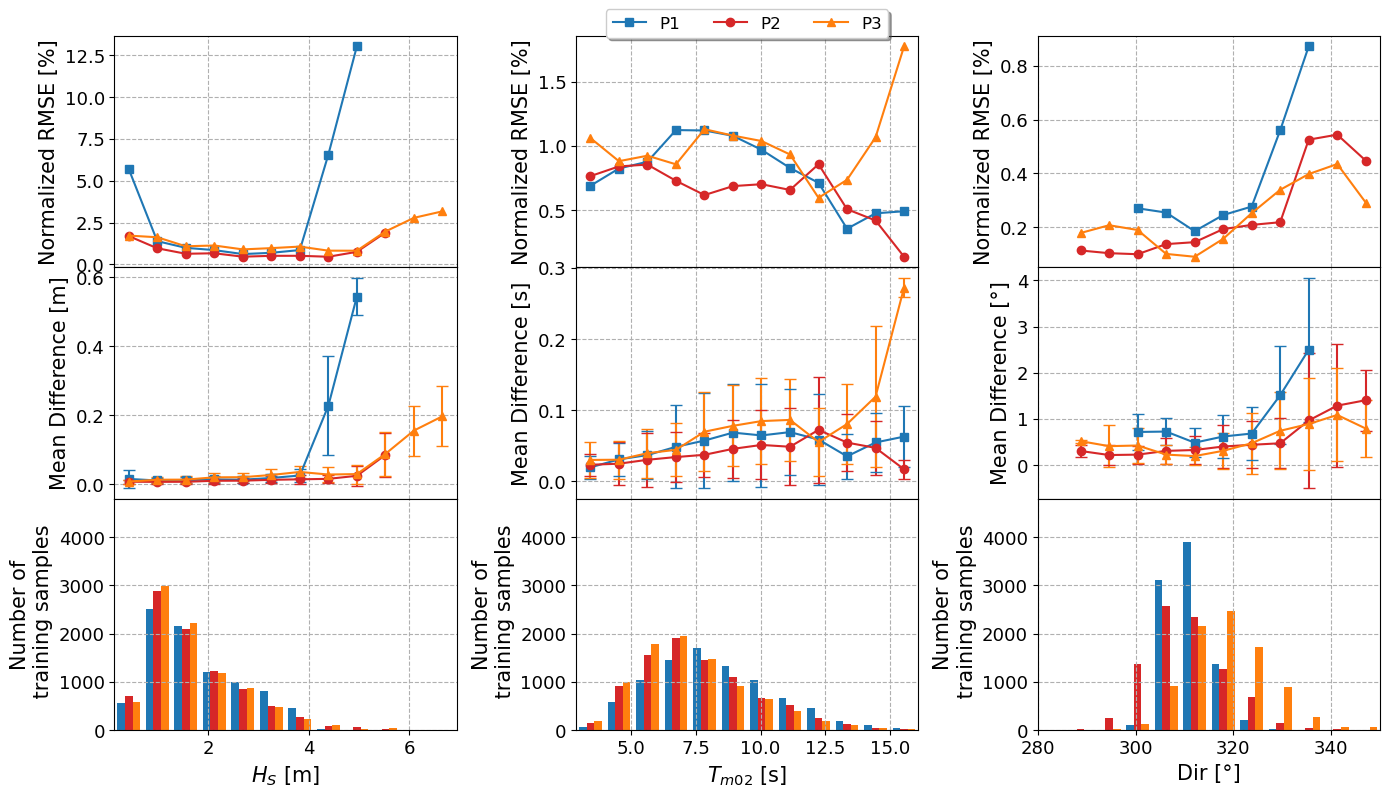

In [4]:
# Constants to easily change font sizes
LABELSIZE = 15
TICKLABELSIZE = 13
LEGENDFONTSIZE = 12

# y-scale for histograms
YMAX = 4800

# Various plot labels
label = ["P1", "P2", "P3"]
xlabel = {0: r"$H_S$ ", 1: r"$T_{m02}$ ", 2: r"Dir "}
units = {0: "[m]", 1: "[s]", 2: "[°]"}


fig, axs = plt.subplots(3, 3, figsize=(14,8))

# Loop over the three variables
for nvar in range(len(var)):
    
    min_max_range = get_range(zip(xi,yi), nvar, model_dir)
    
    # For same scale as in paper
    if nvar == 2:
        min_max_range = (280, 350)
    
    # Get the mean error and difference for the nbox boxes
    box_NRMSE, box_diff, box_diff_std, mid_pos, HR_train = get_plotting_data(
        nvar, xi, yi, model_dir, var, npts, nbox, sample_start, min_max_range
    )
    
    # And plot them
    axs[0, nvar].plot(mid_pos, box_NRMSE[0], label=label[0], marker='s', 
                      color="tab:blue")
    axs[0, nvar].plot(mid_pos, box_NRMSE[1], label=label[1], marker='o',
                      color="tab:red")
    axs[0, nvar].plot(mid_pos, box_NRMSE[2], label=label[2], marker='^',
                      color="tab:orange")
    axs[1, nvar].errorbar(mid_pos, box_diff[0,:], yerr=box_diff_std[0,:],
                          color="tab:blue", marker='s', capsize=4)
    axs[1, nvar].errorbar(mid_pos, box_diff[1,:], yerr=box_diff_std[1, :],
                          color="tab:red", marker='o', capsize=4)
    axs[1, nvar].errorbar(mid_pos, box_diff[2,:], yerr=box_diff_std[2,:],
                          color="tab:orange", marker='^', capsize=4)
    axs[2, nvar].hist(HR_train, nbox, label=label, range=min_max_range,
                      color=["tab:blue", "tab:red", "tab:orange"])
    
    axs[0, nvar].grid(True, axis="both", ls="--")
    axs[0, nvar].set_xlim(*min_max_range)
    axs[0, nvar].set_ylabel("Normalized RMSE [%]", size=LABELSIZE)
    axs[0, nvar].tick_params(axis='both', left=True, top=False, right=False,
                             bottom=False, labelleft=True, labeltop=False,
                             labelright=False, labelbottom=False,
                             labelsize=TICKLABELSIZE)
    
    axs[1, nvar].grid(True, axis="both", ls="--")
    axs[1, nvar].set_xlim(*min_max_range)
    axs[1, nvar].set_ylabel("Mean Difference " + units[nvar], size=LABELSIZE)
    axs[1, nvar].tick_params(axis='both', left=True, top=False, right=False,
                             bottom=False, labelleft=True, labeltop=False,
                             labelright=False, labelbottom=False,
                             labelsize=TICKLABELSIZE)

    axs[2, nvar].grid(True, axis="both", ls="--")
    axs[2, nvar].set_xlim(*min_max_range)
    axs[2, nvar].set_ylim(0, YMAX)
    axs[2, nvar].set_ylabel("Number of\n training samples", size=LABELSIZE)
    axs[2, nvar].set_xlabel(xlabel[nvar] + units[nvar], size=LABELSIZE)
    axs[2, nvar].tick_params(axis='both', labelsize=TICKLABELSIZE)
    
    
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          fancybox=True, shadow=True, ncol=3, fontsize=LEGENDFONTSIZE)
    

plt.tight_layout()
plt.subplots_adjust(hspace=0.0)


fdir = Path("Plots")
fname = f"ErrMeanStdAndDiff_mdir{model_dir}.png"

if save:
    if not fdir.exists():
        fdir.mkdir()
    plt.savefig(fdir / fname)

plt.show()